# Transfer learning using MobileNetV2

# Transfer learning involves using a pre-trained model and then modifying the final layer to have the correct number of classes.
# This is a good way to save time and improve the accuracy of the model.

# Steps are as follows:
# 1. Load the pre-trained model
# 2. Modify the final layer to have the correct number of classes
# 3. Train the model on the new dataset
# 4. Save the model

In [2]:
# import the necessary libraries to perform the above steps using pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import transforms, models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
import numpy as np

# ensure that Mac M1 GPU is being used
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# load the pre-trained model
model = models.mobilenet_v2(pretrained=True)

# print the model architecture
#

/Users/fergusproctor/miniforge3/envs/hand_gesture_detection/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/fergusproctor/miniforge3/envs/hand_gesture_detection/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /Users/fergusproctor/miniforge3/envs/hand_gesture_detection/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/lib/libjpeg.9.dylib' (no such file), '/libjpeg.9.dylib' (no such file), '/Users/fergusproctor/miniforge3/envs/hand_gesture_detection/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/fergusproctor/miniforge3/envs/hand_gesture_detection/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/fergusproctor/miniforge3/envs/hand_gesture_detection/lib/python3.9/lib-dynload/../../libjpeg.9.dy

In [3]:
# save path to training data at /Users/fergusproctor/Library/CloudStorage/OneDrive-Personal/Documents/Robotics Masters/Vision por Computadora/Proyecto Vision/Proyecto Vision-Fergus’s MacBook Air
training_data_path = "/Users/fergusproctor/dev/hand_gesture_detection/src/CNN/Proyecto Vision-Fergus’s MacBook Air/asl_alphabet_train/asl_alphabet_train"


train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225]))
])



# load the training data
full_training_data = datasets.ImageFolder(root=training_data_path, transform=train_transforms)
class_idx = full_training_data.class_to_idx
print(class_idx)
num_classes = len(full_training_data.classes)
print(full_training_data.classes)

# Calculate the number of samples for the test set (10% of the total data)
test_size = int(0.1 * len(full_training_data))  # 10% of the dataset
train_size = len(full_training_data) - test_size  # Remaining 90% for training


# Split the data into training and test sets
train_data, test_data = random_split(full_training_data, [train_size, test_size])

# Calculate 10% of the dataset
subset_size = int(1 * len(train_data))
indices = np.random.permutation(len(train_data))[:subset_size]  # Randomly select 10%

# Create a subset
train_data = Subset(train_data, indices)





# Create DataLoaders for both training and test datasets
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Print the number of images in the training and test sets
print(f"Number of images in the training set: {len(train_data)}")
print(f"Number of images in the test set: {len(test_data)}")





{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Number of images in the training set: 78300
Number of images in the test set: 8700


In [4]:
print(len(train_data))

78300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


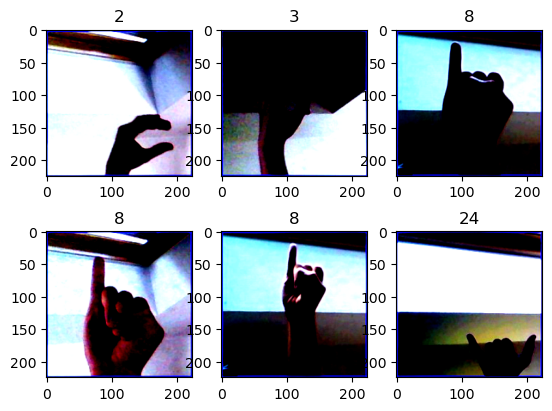

In [5]:
# show 6 random training images
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(train_data[i][0].permute(1, 2, 0))
    plt.title(train_data[i][1])
plt.show()

In [6]:
# create data loaders which we can pass to model later
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


In [9]:
# update the final layer of the model to have the correct number of classes, which is the 
# number of classes in the training data
num_classes = len(full_training_data.classes)
print(num_classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# print the model architecture
print(model)

29
MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, e

In [7]:
print(device)

mps


In [17]:
criterion = nn.CrossEntropyLoss()

model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [18]:
import torch
from torchvision import models

# Instantiate the model (same architecture as before)
model = models.mobilenet_v2(pretrained=False)

# If you made changes to the model, apply them (e.g., modifying the classifier)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 29)

# Load the saved model weights
model.load_state_dict(torch.load('mobilenet_asl_100_percent_5_epoch.pth'))


model = model.to(device)
# Set the model to evaluation mode for inference
model.eval()

print("Model loaded successfully!")


/var/folders/dv/3vlkd_t53j9gr9ggfhz4wg2w0000gn/T/ipykernel_21403/158839894.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mobilenet_a

Model loaded successfully!


In [19]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

Test Loss: 0.9167
Test Accuracy: 0.8852

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       300
           1       0.89      0.94      0.92       295
           2       0.97      0.97      0.97       289
           3       0.98      0.94      0.96       286
           4       0.81      0.91      0.86       293
           5       0.95      0.96      0.96       308
           6       0.91      0.90      0.90       319
           7       0.95      0.96      0.95       307
           8       0.90      0.84      0.87       316
           9       0.89      0.88      0.88       285
          10       0.90      0.87      0.88       343
          11       0.91      0.93      0.92       320
          12       0.88      0.77      0.82       314
          13       0.82      0.87      0.85       294
          14       0.91      0.96      0.93       289
          15       0.96      0.96      0.96       301
          16     

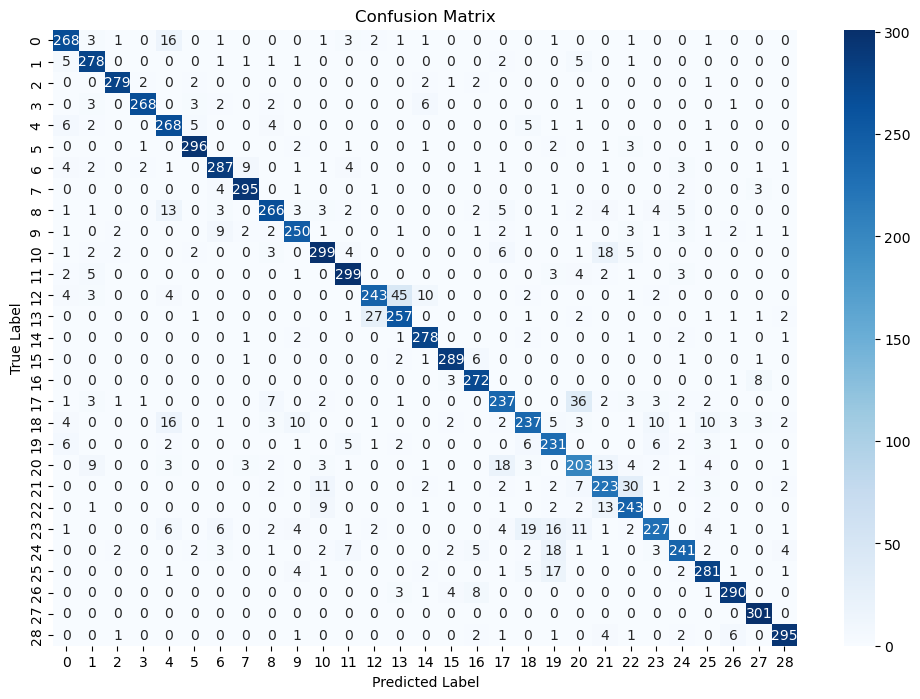

In [20]:
# test out model

# Set model to evaluation mode
model.eval()

# Initialize lists to store predictions and actual labels
predictions = []
actual_labels = []
running_test_loss = 0.0

with torch.no_grad():  # Disable gradient calculation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate loss
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()
        
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Store predictions and labels
        predictions.extend(predicted.cpu().numpy())
        actual_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(actual_labels, predictions)
print(f"Test Loss: {running_test_loss/len(test_loader):.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(actual_labels, predictions))

# Create confusion matrix
cm = confusion_matrix(actual_labels, predictions)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


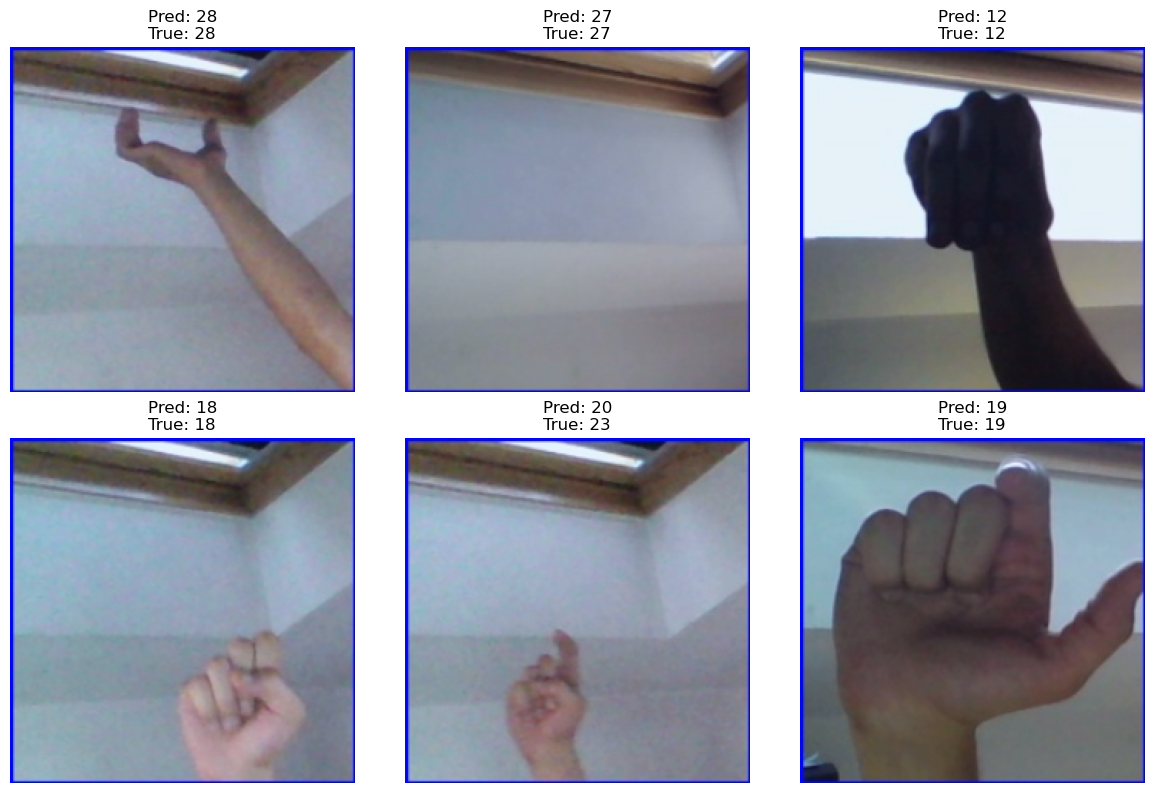

In [21]:
# show test images, predictions and true classes alongside each other
# Get a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Make predictions
with torch.no_grad():
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs.data, 1)

# Convert tensors to numpy arrays
images = images.cpu().numpy()
predicted = predicted.cpu().numpy()
labels = labels.cpu().numpy()

# Plot 6 images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for idx in range(6):
    # Get the image and normalize it
    img = np.transpose(images[idx], (1, 2, 0))
    img = (img - img.min()) / (img.max() - img.min())
    
    # Plot image
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f'Pred: {predicted[idx]}\nTrue: {labels[idx]}')

plt.tight_layout()
plt.show()